In [15]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import torch
import hamiltorch
%matplotlib inline

from src.utils.make_environment import transition_matrix, insert_walls_into_T
# from src.utils.optimization import soft_q_iteration_torch
from src.utils.inference.likelihood import log_likelihood_torch

In [18]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

from src.utils.inference.sampling import bayesian_parameter_learning
from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)
from src.utils.visualization import (
    plot_posterior_distribution,
    plot_environment,
    plot_trajectories,
    mcmc_diagnostics,
    plot_log_likelihood,
)
from src.utils.constants import ParamTuple, beta_agent
from src.utils.optimization import soft_q_iteration
from src.utils.inference.rollouts import generate_n_trajectories

np.set_printoptions(linewidth=160, precision=2)

Create Environment


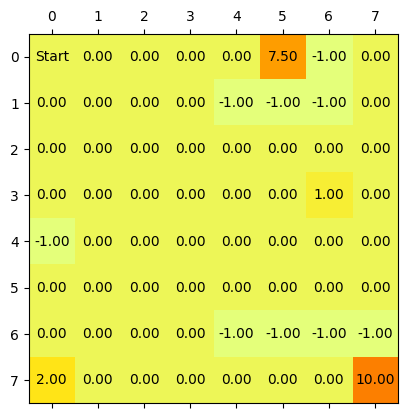

In [19]:
# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 15
n_posterior_samples = 10
n_traj_per_sample = 2

## 0.2 Setup the environment
N, M = 8, 8
n_states, n_actions = N * M, 4

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[0, M - 3] = 7.5
agent_R[3, M - 2] = 1
agent_R[N - 1, 0] = 2
agent_R[N - 1, M - 1] = 10
agent_R[4, 0] = -1

agent_R[1, M - 4] = -1
agent_R[1, M - 3] = -1
agent_R[1, M - 2] = -1
agent_R[0, M - 2] = -1

agent_R[N - 2, M - 4] = -1
agent_R[N - 2, M - 3] = -1
agent_R[N - 2, M - 2] = -1
agent_R[N - 2, M - 1] = -1

plot_environment(agent_R.reshape(N, M), [])

# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.8
p_true = 0.999

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

n_samples_MC = 1_000
n_burnin_MC = 500

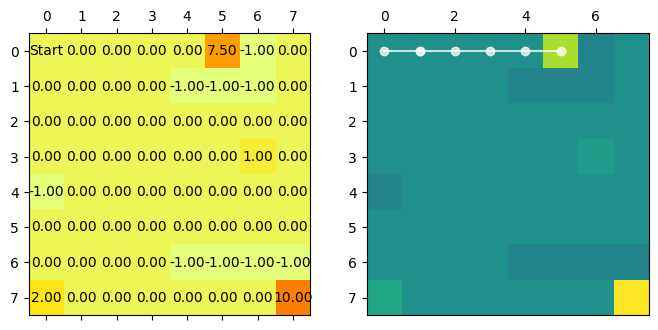

In [20]:
# Generate 2 trajectories in the env starting environment
wall_states = []
T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=100)

env_agent = Environment(
    N=N,
    M=M,
    T_true=T_true,
    wall_states=wall_states,
    R_sample_mean=None,
    start_state=0,
    n_walls=None,
)

# Generate trajectories
trajectories = generate_n_trajectories(
    T_agent,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories_1 = [(env_agent, trajectories)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

In [21]:
def soft_q_iteration_torch(
    R: torch.Tensor,  # R is a one-dimensional tensor with shape (n_states,)
    T_agent: torch.Tensor,
    gamma: float,
    beta: float,  # Inverse temperature parameter for the softmax function
    tol: float = 1e-6,
) -> torch.Tensor:
    n_states, n_actions, _ = T_agent.shape
    V = torch.zeros(n_states, dtype=torch.float64)
    Q = torch.zeros((n_states, n_actions), dtype=torch.float64)
    policy = torch.zeros((n_states, n_actions), dtype=torch.float64)

    while True:
        for s in range(n_states):
            for a in range(n_actions):
                # Calculate the Q-value for action a in state s
                Q[s, a] = R[s] + gamma * torch.dot(T_agent[s, a], V)

        # Apply softmax to get a probabilistic policy
        max_Q = torch.max(Q, axis=1, keepdim=True)[0]
        exp_Q = torch.exp(beta * (Q - max_Q))  # Subtract max_Q for numerical stability
        policy = exp_Q / torch.sum(exp_Q, axis=1, keepdim=True)

        # Calculate the value function V using the probabilistic policy
        V_new = torch.sum(
            policy * Q.clone(), axis=1
        )  # no idea why we need this clone operation here @Lars

        # Check for convergence
        if torch.max(torch.abs(V - V_new)) < tol:
            break

        V = V_new
    return policy

In [22]:
def log_likelihood_torch(T, policy, trajectory):
    log_likelihood = torch.tensor(0.0)
    for s, a, next_s in trajectory[:-1]:
        log_likelihood = log_likelihood + torch.log(T[s, a, next_s] * policy[s, a])
    return log_likelihood

In [23]:
def normalize(val) -> float:
    """
    normalizes from (-infty, infty) to (0.5, 1)
    """
    return 0.75 + 0.25 * torch.tanh(val)


def log_prob_func(parameter_sample):
    p = normalize(parameter_sample[0])
    gamma = normalize(parameter_sample[1])
    R = parameter_sample[2:]

    log_likelihood = 0.0

    for env, trajectories in expert_trajectories_1:
        T_agent = transition_matrix(env.N, env.M, p=p, absorbing_states=goal_states)
        T_agent = insert_walls_into_T(
            T_agent, wall_indices=env.wall_states
        )  # this is new
        T_agent = torch.from_numpy(T_agent).double()
        policy = soft_q_iteration_torch(R, T_agent, gamma=gamma, beta=20)
        log_likelihood = torch.stack(
            [log_likelihood_torch(env.T_true, policy, traj) for traj in trajectories]
        ).sum()
        # for traj in trajectories:
        #     log_likelihood += log_likelihood_torch(env.T_true, policy, traj)
    # print("log likelihood: ", log_likelihood)
    return log_likelihood
    # return torch.tensor(log_likelihood)

In [24]:
num_samples = 2_000
step_size = 0.3
num_steps_per_sample = 2

hamiltorch.set_random_seed(123)
params_init = torch.zeros(N * M + 2) + 0.5
params_hmc = hamiltorch.sample(
    log_prob_func=log_prob_func,
    params_init=params_init,
    num_samples=num_samples,
    step_size=step_size,
    num_steps_per_sample=num_steps_per_sample,
)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:15:34:34 | 0d:00:00:00 | #################### | 2000/2000 | 0.04       
Acceptance Rate 0.00
